# About
Here I want to explore different machine learning models for timeseries prediction. I use a real timeseries dataset that I found on from [Kaggle](www.kaggle.com).

I worked on this while taking the [DeepLearning.AI course "Sequences, Time Series and Prediction"](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction).

## Concepts covered
* Univariate timeseries
* Deep neural networks
* Recurrent neural networks (RNN)
* LSTM (Long short-term Memory) models
* Multilayer perceptron (MLP) model
* Convolutional layers

## Tools used
* Tensorfow: `tf.data.Dataset`, `tf.keras.Sequential`
* Kaggle API
* Pandas

# Imports, setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import itertools

In [2]:
from scipy.signal import periodogram

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
from statsmodels.tsa.stattools import acf, pacf

In [22]:
import statsmodels.api as sm

## Download data from Kaggle
This step requires using the [Kaggle API](https://github.com/Kaggle/kaggle-api) and authenticating using the API credentials. In order to focus on model concepts rather than digging into the data, I pick a well-studied dataset: [monthly sunspot activity](https://www.kaggle.com/robervalt/sunspots/activity). This is the most popular sunspot dataset on Kaggle. As the data description states, sunspots are phenomena on the sun which vary with a approximately 11-year cycle. 

In [5]:
api = KaggleApi()
try:
    api.authenticate()
except Exception as e:
    print("Kaggle authentication failed!")
    raise e

sunspot_datasets = api.datasets_list(search='sunspots')
sunspot_datasets.sort(key=lambda d: (d['voteCount'], d['viewCount']), reverse=True)

for d in sunspot_datasets:
    # d is a dict
    print(f"\"{d['title']}\": \n\t votes: {d['voteCount']}; views: {d['viewCount']}; {d['url']}")

"Sunspots": 
	 votes: 84; views: 23670; https://www.kaggle.com/robervalt/sunspots
"Daily Sun Spot Data (1818 to 2019)": 
	 votes: 22; views: 4430; https://www.kaggle.com/abhinand05/daily-sun-spot-data-1818-to-2019
"climate change": 
	 votes: 15; views: 7521; https://www.kaggle.com/econdata/climate-change
"NASA and NOAA  Satellites Solar-Wind Dataset": 
	 votes: 8; views: 887; https://www.kaggle.com/arashnic/soalr-wind
"RiseInTemp_dataset": 
	 votes: 6; views: 2407; https://www.kaggle.com/vageeshabudanur/riseintemp-dataset
"Monthly Sunspots": 
	 votes: 0; views: 212; https://www.kaggle.com/hugoherrera11/monthly-sunspots
"Sunspots": 
	 votes: 0; views: 95; https://www.kaggle.com/parichatapi/sunspots
"pyspark-library": 
	 votes: 0; views: 77; https://www.kaggle.com/rhtsingh/pysparklibrary


In [6]:
ref="robervalt/sunspots" 
datafiles = api.dataset_list_files(ref).files
print(f"Files in dataset \"{ref}\": {datafiles}")

# Download and unzip dataset into current directory
api.dataset_download_files(ref, unzip=True)
csv_file = str(datafiles[0])
!ls {csv_file}

Files in dataset "robervalt/sunspots": [Sunspots.csv]
Sunspots.csv


The dataset is a basic univariate timeseries, just dates and monthly sunspot numbers:

In [7]:
df = pd.read_csv(csv_file)
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


## Data preprocess

In [8]:
df = df.drop(columns=df.columns[0]).rename(
    columns={df.columns[1]: 'date', df.columns[2]: 'sunspots'})
df.date = pd.to_datetime(df.date)
print(df.head())

        date  sunspots
0 1749-01-31      96.7
1 1749-02-28     104.3
2 1749-03-31     116.7
3 1749-04-30      92.8
4 1749-05-31     141.7


In [9]:
# Assert that the timestamp differences are monthly: either +1 month or -11 (new year, Jan-Dec)
print(set(df.date.dt.month.diff()[1:].unique()) == {1, -11})

True


# Data exploration

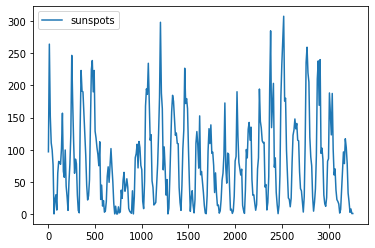

In [10]:
sns.lineplot(data=df[::10],);

In [11]:
len(df)

3265

We already are given the approximately, but this can be made more exact/verified by looking at the frequency distribution 
(the calculated [power spectral density](https://en.wikipedia.org/wiki/Spectral_density), known as a [periodogram](https://en.wikipedia.org/wiki/Periodogram))

Period at max in months: 130.6 months = 10.883333333333333 years.
Left, right: 136.04166666666666, 125.57692307692308 months.


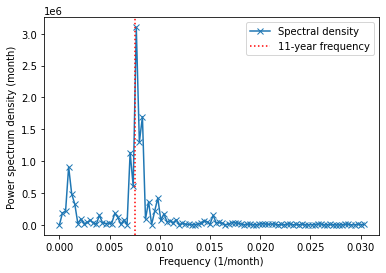

In [12]:
f, spec = periodogram(df.sunspots)

plt.plot(f[:100], spec[:100], 'x-', label='Spectral density')
plt.xlabel('Frequency (1/month)');
plt.ylabel("Power spectrum density (month)")

plt.axvline(x=1/(11*12), linestyle=':', color='red', label='11-year frequency')

plt.legend()
imax = np.argmax(spec)
left, center, right = 1/f[imax-1:imax+2] # years
print(f"Period at max in months: {center} months = {center/12} years.\nLeft, right: {left}, {right} months.")

However we see that there are also other relevatn frequencies in the spectrum, such as the peak at very low frequencies, corresponding to ~91 years.

When applying differencing methods for the modeling, a more direct metric for determining the seasonality (in integer units too) is to look at the autocorrelation function, i.e. the correlations of data separated by a certain lag. The autocorrelation and the spectral density are similar in that they both quantify correlations over time, but different (the relationship between them is given by the [Wiener-Khinchin theorem](https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem)).

2nd max autocorrelation value: [0.57929215 0.58087362 0.57577442]
Lag at 2nd max of autocorrelation: 128
Number of periods in dataset: 25.5078125


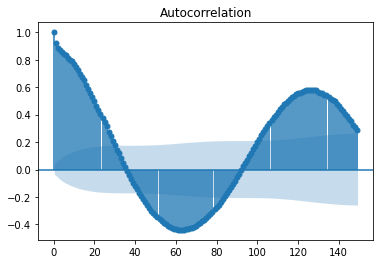

In [63]:
plot_acf(df.sunspots, lags=range(0,150));

acf_vals = acf(df.sunspots, nlags=150, fft=False)

# Find index of the second max
start = 60
period = np.argmax(acf_vals[start:]) + start
print("2nd max autocorrelation value:", acf_vals[period-1:period+2])
print("Lag at 2nd max of autocorrelation:", period)
print(f"Number of periods in dataset: {len(df)/period}")

# Baseline model: ARIMA

In [18]:
def predict_ARIMA(x, times, model, model_fit):
    "Make predictions for trained model using data x"
    tmp_model = ARIMA(x, order=model.order, trend=model.trend, seasonal_order=model.seasonal_order)
    tmp_fit = tmp_model.smooth(model_fit.params)
    yhat = tmp_fit.predict(times[0], times[-1])
    return yhat

In [19]:
def evaluate(y, yhat):
    mse = np.mean((y - yhat)**2)
    mae = np.mean(np.abs(y-yhat))
    return dict(mse=mse, mae=mae)

## Some preliminary tests
ARIMA(0,1,0) is a very simple model, just predicting the next month to be the same as the current month.

ARIMA model orders (0, 1, 0) (0, 0, 0, 128)
split: 2048, trend: None
{'mse': 692.6580197206245, 'mae': 18.875184880854558}


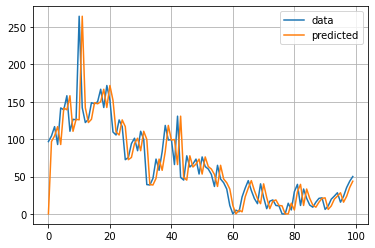

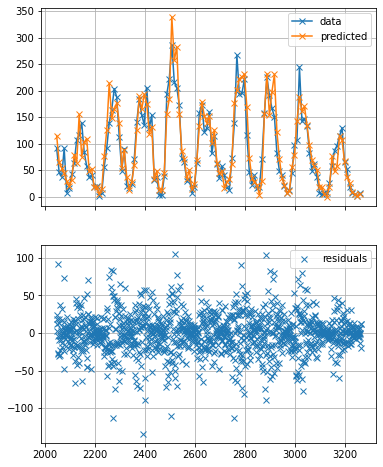

In [88]:
# Configuration
split = period*16
p, d, q = 0, 1, 0
P, D, Q, S = 0, 0, 0, period
seasonal_order = P, D, Q, S
order = (p, d, q)
trend = None if (d or D) else 'ct'
arima_config = dict(order=order, seasonal_order=seasonal_order, trend=trend)
print("ARIMA model orders", order, seasonal_order)    
print(f"split: {split}, trend: {trend}")

# Fit and predict
baseline = sm.tsa.statespace.SARIMAX(df.sunspots[:split], **arima_config)
baseline_fit = baseline.fit()
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), baseline, baseline_fit)

# plot
plt.grid()
plt.plot(df.sunspots[:100], label='data')
plt.plot(yhat[:100], label='predicted')
plt.legend()

fig, axes = plt.subplots(2,1, figsize=(6, 8), sharex=True)
ax = axes[0]
ax.grid()
ax.plot(df.sunspots[split::10], '-x', label='data')
ax.plot(yhat[split::10], '-x', label='predicted')
ax.legend()

ax = axes[1]
ax.grid()
res = yhat - df.sunspots
ax.plot(res[split:], 'x', label='residuals');
ax.legend()

# Print metrics
print(evaluate(df.sunspots[split:], yhat[split:]))

We see that already this model is doing pretty good in forecasting the next step. But there are still large residual values, seemingly periodically occurring. I try to see if adding seasonal differencing terms help, but it actually significantly decreases the performance of the model:

ARIMA model orders (0, 1, 0) (0, 1, 0, 128)
split: 2048, trend: None
{'mse': 1279.279745275281, 'mae': 25.886359901396993}


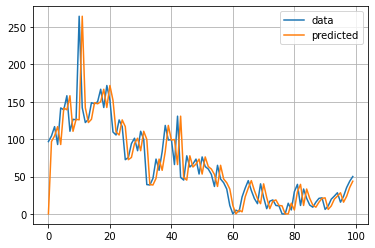

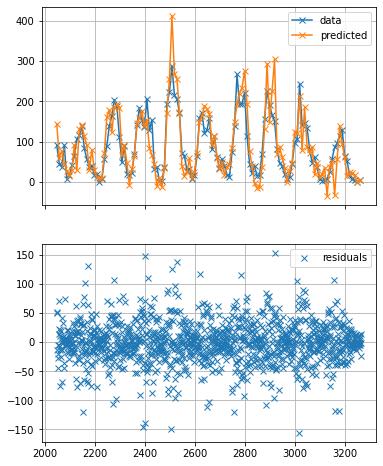

In [89]:
# Configuration
split = period*16
p, d, q = 0, 1, 0
P, D, Q, S = 0, 1, 0, period
seasonal_order = P, D, Q, S
order = (p, d, q)
trend = None if (d or D) else 'ct'
arima_config = dict(order=order, seasonal_order=seasonal_order, trend=trend)
print("ARIMA model orders", order, seasonal_order)    
print(f"split: {split}, trend: {trend}")

# Fit and predict
baseline = sm.tsa.statespace.SARIMAX(df.sunspots[:split], **arima_config)
baseline_fit = baseline.fit()
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), baseline, baseline_fit)

# plot
plt.grid()
plt.plot(df.sunspots[:100], label='data')
plt.plot(yhat[:100], label='predicted')
plt.legend()

fig, axes = plt.subplots(2,1, figsize=(6, 8), sharex=True)
ax = axes[0]
ax.grid()
ax.plot(df.sunspots[split::10], '-x', label='data')
ax.plot(yhat[split::10], '-x', label='predicted')
ax.legend()

ax = axes[1]
ax.grid()
res = yhat - df.sunspots
ax.plot(res[split:], 'x', label='residuals');
ax.legend()

# Print metrics
print(evaluate(df.sunspots[split:], yhat[split:]))

As a last test I add an seasonal MA(1) term to see if that helps the seasonal ARIMA model compete with the naiva ARIMA(0,1,0) model:

ARIMA model orders (0, 1, 0) (0, 1, 1, 128)
split: 2048, trend: None
{'mse': 725.7241883005468, 'mae': 19.587603019185867}


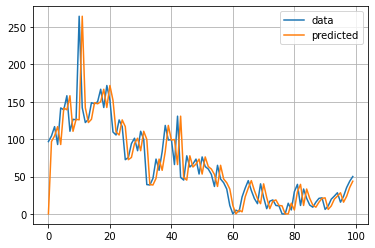

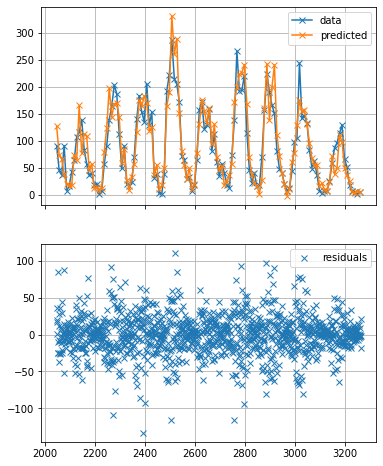

In [90]:
# Configuration
split = period*16
p, d, q = 0, 1, 0
P, D, Q, S = 0, 1, 1, period
seasonal_order = P, D, Q, S
order = (p, d, q)
trend = None if (d or D) else 'ct'
arima_config = dict(order=order, seasonal_order=seasonal_order, trend=trend)
print("ARIMA model orders", order, seasonal_order)    
print(f"split: {split}, trend: {trend}")

# Fit and predict
baseline = sm.tsa.statespace.SARIMAX(df.sunspots[:split], **arima_config)
baseline_fit = baseline.fit()
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), baseline, baseline_fit)

# plot
plt.grid()
plt.plot(df.sunspots[:100], label='data')
plt.plot(yhat[:100], label='predicted')
plt.legend()

fig, axes = plt.subplots(2,1, figsize=(6, 8), sharex=True)
ax = axes[0]
ax.grid()
ax.plot(df.sunspots[split::10], '-x', label='data')
ax.plot(yhat[split::10], '-x', label='predicted')
ax.legend()

ax = axes[1]
ax.grid()
res = yhat - df.sunspots
ax.plot(res[split:], 'x', label='residuals');
ax.legend()

# Print metrics
print(evaluate(df.sunspots[split:], yhat[split:]))

This did help decreasing both MSE and MAE, but still it performs significantly worse (MAE=19.6) than the simple ARIMA(0,1,0) model (MAE=18.9). It should be noted also that this took _much_ longer to fit and predict.

On the other hand one can note that the forecast done here was just one-step ahead. For multistep prediction, possible the seasonal model has advantages since it will have access to more data of the past. 

## Hyperparameter search

I want to perform a smallish hyperparmeter search for ARIAM to find a somewhat more competitive baseline.

Suprisingly (to me), as we saw above, adding seasonal components was not straightforward and required being bit restrictive. For instance, ARIMA$(0, 1, 0)(1, 1, 1)_{132}$ crashed the kernel. Potentially an implementation issue in the ARIMA function (using a lot of memory?) or in my implementation of the prediction). Other handpicked combinations deteriorated performance.
From what I understand, picking these parameter typically requires having some knowledge and experience; [Prof. Nau's](https://people.duke.edu/~rnau/seasarim.htm) lecture notes are a great resource for this. 

Here, I will skip seasonal orders becuase of the above reasons and perform a small search on non-seasonal orders only.

In [133]:
configs = itertools.product(*(range(7) for _ in range(3)), # p, d, q in (0, 1, 2, ...)
                            *(range(1) for _ in range(3)), # P, D, Q in (0)
                            (0,)) # seasonality in 0, 11 years (1 year = 12 months)

verbose = False
metrics = dict()

for i, c in enumerate(configs):
    if i % 10 == 0:
        print(i, end='\t')
    if i % 100  == 0:
        print()

    p, d, q, P, D, Q, S = c
    if S == 0 and max(P, D, Q) > 0:
        # Skip seasonal orders > 0 if S = 0 
        # (do only 0, 0, 0, 0)
        continue
    seasonal_order = P, D, Q, S
    order = (p, d, q)
    trend = None if (d or D) else 'ct'
    arima_config = dict(order=order, seasonal_order=seasonal_order, trend=trend)
    if verbose:
        print("ARIMA model orders", order, seasonal_order)    
        print(f"split: {split}, trend: {trend}")
    
    # Train on `split` number of samples
    model = ARIMA(df.sunspots[:split], **arima_config)
    try:
        fit = model.fit()
    except Exception as e:
        print ("Error in fit", e)
        continue

    # Validation MSE and MAE
    # Predict on all, evaluate on non-training data
    yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), model, fit)
    metrics[c] = evaluate(df.sunspots[split:], yhat[split:])
    
    if verbose:
        print(f"Metric: {metrics[c]}")
        print()

0	
10	20	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


30	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


40	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


50	60	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


70	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


80	90	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


100	


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


110	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

120	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

130	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error in fit LU decomposition error.


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


140	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


150	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

160	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

170	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

Error in fit LU decomposition error.
180	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

190	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


200	


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

210	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

220	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

230	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error in fit LU decomposition error.


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


240	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: No

250	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

260	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

270	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

280	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

Error in fit LU decomposition error.
290	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

300	


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

310	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

320	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

Error in fit LU decomposition error.


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


330	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

340	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [134]:
len(metrics)

338

In [355]:
def plot_pdq_distributions(metrics, name='mae', num_top=100):
    """Plot distributions of top configurations."""
    # Sort by the metrics
    mae = [(k, v[name]) for k, v in metrics.items()]
    mae.sort(key=lambda kv: kv[1])
    
    # Extract separate lists of the p, q, q hyperparameters
    configs, values = list(zip(*mae))
    ps, ds, qs, *_ = list(zip(*configs))

    fig, axes = plt.subplots(1,3, figsize=(3*4, 4))

    #for (i, x), name in zip(enumerate(top_pdq),'pdq'):
    plt.suptitle(f'Distribution of ARIMA (p,d,q) parameters for top {num_plot} configs')
    for params, name, i in zip([ps, ds, qs], 'pdq', range(3)):
        #print(len(params), name, i)
        sns.countplot(x=list(params)[:num_top], ax=axes[i], label=name, color='dodgerblue')
        axes[i].legend()

If we perform an analysis of the top 5% configurations, we see that $d=0$ sticks out as an important choice:

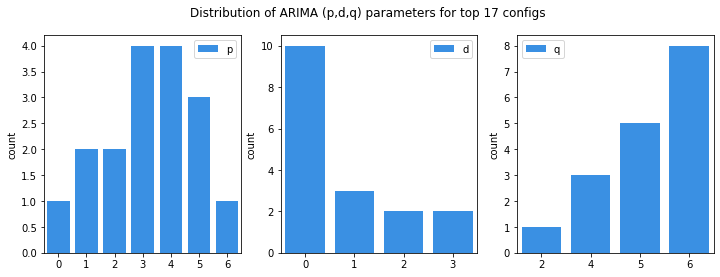

In [367]:
plot_pdq_distributions(metrics, num_top=len(metrics)//20 + 1)

Also, it looks like $p=3,4$ and $q=6$ (highest value) are good choices. Of course, one should keep in mind these kind of plots don't take into account any correlation between the different hyperparameters, just looks at the independently of on another. 

To get an idea of what how the actual performance values change with respect to the configurations, I plot the sorted MAE values:

In [368]:
def plot_metric_sorted(metrics, name='mae', num_plot=100):
    m = [(k, v[name]) for k, v in metrics.items()]
    m.sort(key=lambda kv: kv[1])
    configs, values= list(zip(*mae))

    fig, ax = plt.subplots(1)
    ax.plot(values[:num_plot], '-x', label=f'""{name} sorted by "{name}")')
    ax.legend()

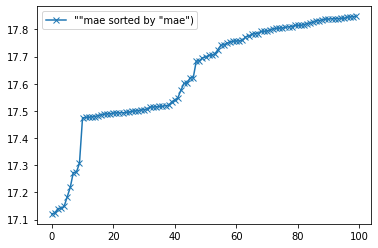

In [369]:
plot_metric_sorted(metrics)

It looks like there's a steep increase in MAE after the 10th best configuration, which is more like the  top 3%:

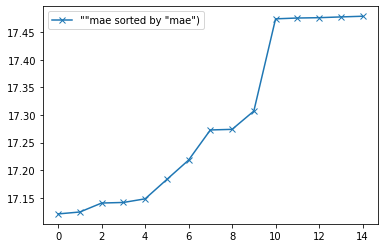

In [370]:
plot_metric_sorted(metrics, num_plot=15)

This means that the top 10 configurations form an elite "cluster" of a sort, which likely share some common features. Since there are quite few data points to deal with we can just look at them:

In [373]:
name='mae'
mae = [(k, v[name]) for k, v in metrics.items()]
mae.sort(key=lambda kv: kv[1])
for i, (k, v) in enumerate(mae[:15]):
    print(f"{i}: {k}, {v}")

0: (3, 0, 5, 0, 0, 0, 0), 17.120758657342208
1: (3, 0, 6, 0, 0, 0, 0), 17.1242484011605
2: (5, 0, 6, 0, 0, 0, 0), 17.14048447820643
3: (2, 0, 4, 0, 0, 0, 0), 17.14152782921944
4: (2, 0, 6, 0, 0, 0, 0), 17.148095960757352
5: (4, 0, 5, 0, 0, 0, 0), 17.183277039876305
6: (4, 0, 6, 0, 0, 0, 0), 17.218339505123183
7: (6, 0, 5, 0, 0, 0, 0), 17.272911960347162
8: (4, 0, 4, 0, 0, 0, 0), 17.274025588334126
9: (5, 0, 4, 0, 0, 0, 0), 17.307147965560976
10: (4, 3, 6, 0, 0, 0, 0), 17.47429699758533
11: (3, 1, 5, 0, 0, 0, 0), 17.47578570018287
12: (5, 1, 6, 0, 0, 0, 0), 17.476401634827837
13: (0, 2, 6, 0, 0, 0, 0), 17.477764135893025
14: (3, 3, 5, 0, 0, 0, 0), 17.47900422585776


It's clear that relatatively large $p$ and $q$ value together with $d=0$ works best. Although this is a small number of configurations, we can look at the counts of the $p$, $d$, $q$ parameters, as before but now only for the top 10 configurations. With larger nubmer of configurations scanned, this kind of analysis will make even more sense.

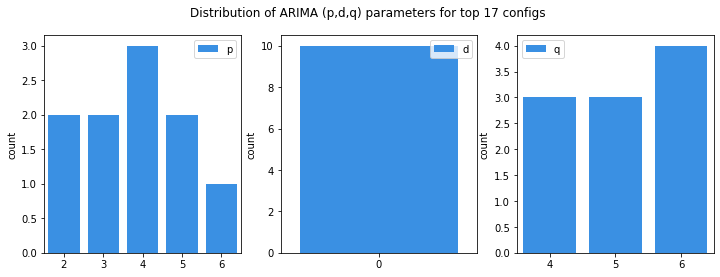

In [374]:
plot_pdq_distributions(metrics, num_top=10)

Based on this $2\leq p \leq5$, $d=0$ and $4\leq q\leq6$ are all good choices. Also, we see from this that there is not very much point in looking at larger $p$ and $q$ values for $d=1$.


In the end, in this case I just want a single configuration that works so **I pick the best one**,
$(p, d, q) = (3, 0, 5)$.
In other cases, one might choose another configuration, for instance taking training time, model architecture or other metrics into account. 

# MLP model
Now I want to see how neural network models perform relative to my ARIMA baseline. I'll start with the simplest case, an MLP model.